# Comparing KS and AD tests in determining if two samples are drawn from two separate distributions

It has been noted freqently that the popular KS test is not as sensitive and powerful as the AD test, specially in small samples (e.g., see [Feigelson & Babu](https://asaip.psu.edu/Articles/beware-the-kolmogorov-smirnov-test), [Hou et al. 2009](http://adsabs.harvard.edu/abs/2009ApJ...702.1199H), [Stephens 1974](https://www.jstor.org/stable/2286009?seq=1#metadata_info_tab_contents)). Here we try to test how well the two perform in a specific case (which can be easily generalized):
When we have two samples of similar size drawn from two normal distributions with same standard deviation but different means. We test sensitivity (via "significance" or null hypothesis probability that the samples are drawn from the same distribution) as a function of separation between the mean of parent distributions and sample size. We generate two samples 1000 times per separation and sample size and estimate the mean NHP over these 1000 iterations.

For computing these tests, we use their implementations in the [Scipy package](https://www.scipy.org/) ([Jones et al. 2001](https://www.scipy.org/citing.html)) under [`scipy.stats.ks_2samp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html) and [`scipy.stats.anderson_ksamp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson_ksamp.html).

In [1]:
import numpy as np
import sys, pickle, scipy
import scipy.stats as sts
from scipy.interpolate import griddata
import joblib
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('font', family='serif')

# Package versions:
print('Running on:')
print(f'\tPython:\t\t{sys.version[:5]}')
print('\tJoblib\t\t{}'.format(joblib.__version__))
print('\tMatplotlib\t{}'.format(plt.matplotlib.__version__))
print('\tNumpy\t\t{}'.format(np.__version__))
print('\tScipy\t\t{}'.format(scipy.__version__))

Running on:
	Python:		3.7.3
	Joblib		0.13.2
	Matplotlib	3.1.0
	Numpy		1.16.4
	Scipy		1.3.0


In [2]:
%matplotlib notebook

In [3]:
def stats_grid(kk):
    ks_prob = np.empty([N_size,N_sep])
    ad_prob = np.empty([N_size,N_sep])
    for i in range(N_sep):
        for j in range(N_size):
            x = np.random.normal(loc=0.0,scale=1.0,size=samp_size[j])
            y = np.random.normal(loc=sep[i],scale=1.0,size=samp_size[j])
            ks_prob[j,i] = sts.ks_2samp(x,y)[1]
            ad_prob[j,i] = sts.anderson_ksamp([x,y])[-1]
    return ks_prob, ad_prob

In [4]:
N_attempts = 2000
N_sep = 50
N_size = 1000
sep = np.linspace(0.0,2.0,N_sep)
samp_size = np.array(range(5,N_size+5))
ks_mean = np.zeros([N_size,N_sep])
ad_mean = np.zeros([N_size,N_sep])
ks_var = np.zeros([N_size,N_sep])
ad_var = np.zeros([N_size,N_sep])

In [5]:
grid_results = np.array(joblib.Parallel(n_jobs=8, verbose=5)(joblib.delayed(stats_grid)(kk) for kk in range(N_attempts)))
pickle.dump(grid_results, open('ks_vs_ad_sim_results.p', 'wb' ))

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed: 11.2min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed: 30.1min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed: 53.9min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed: 85.9min
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed: 124.7min
[Parallel(n_jobs=8)]: Done 866 tasks      | elapsed: 167.8min
[Parallel(n_jobs=8)]: Done 1136 tasks      | elapsed: 218.6min
[Parallel(n_jobs=8)]: Done 1442 tasks      | elapsed: 277.1min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed: 338.5min
[Parallel(n_jobs=8)]: Done 2000 out of 2000 | elapsed: 376.6min finished


<IPython.core.display.Javascript object>


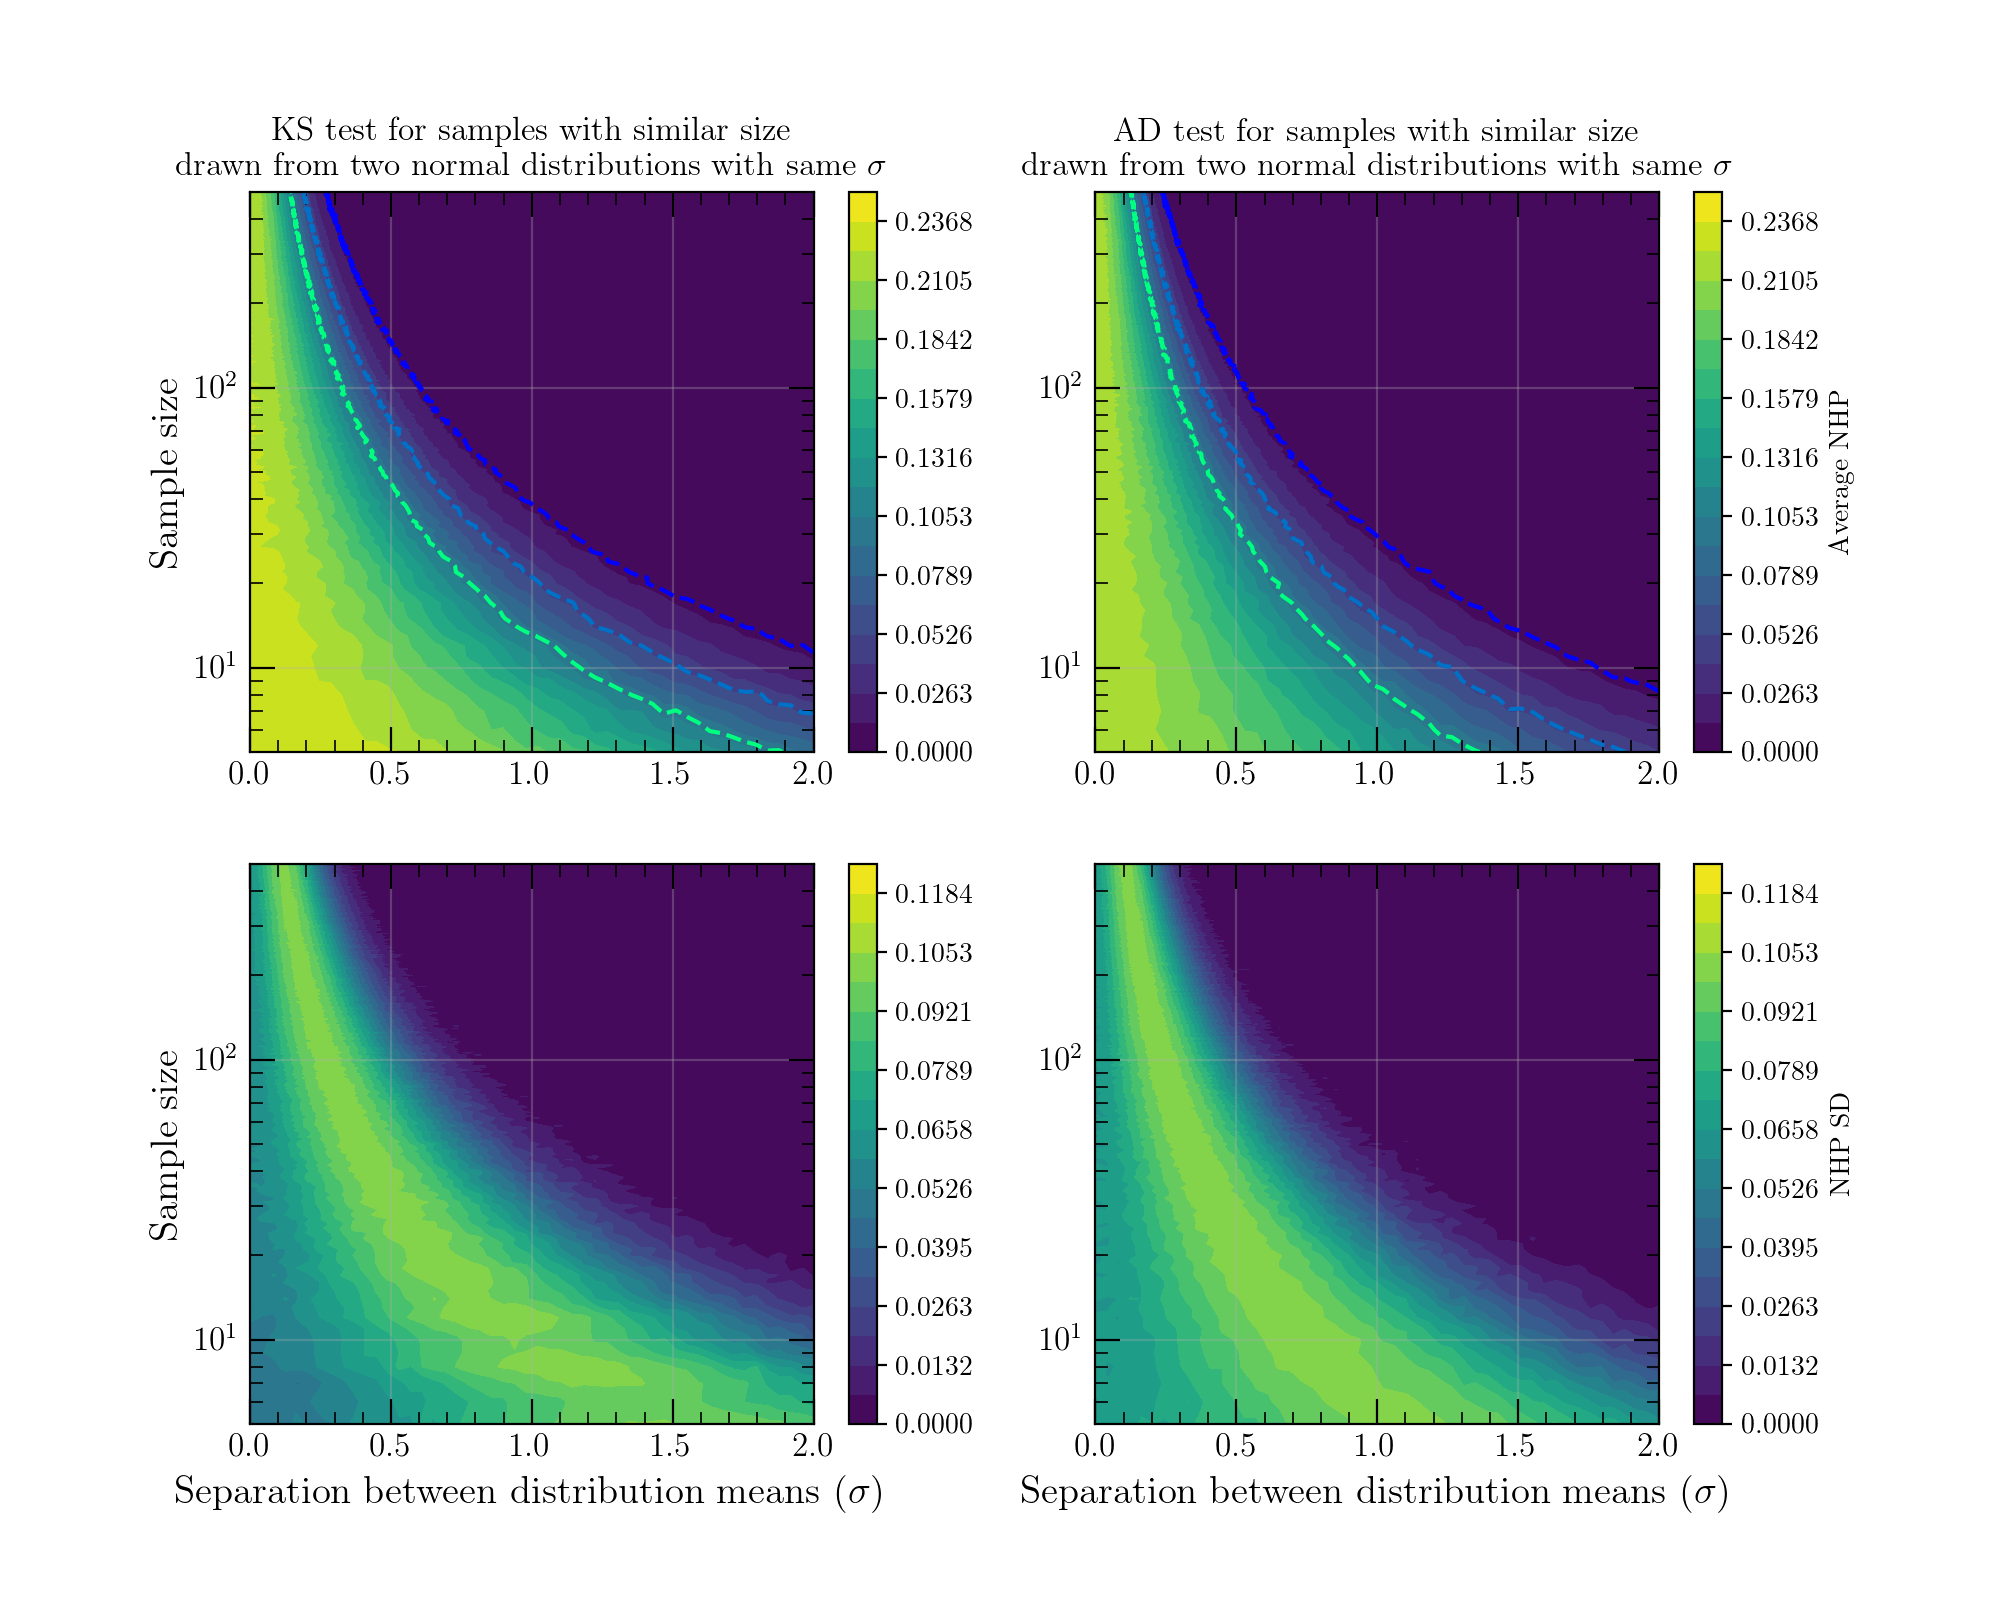

In [5]:
grid_results = pickle.load(open('ks_vs_ad_sim_results.p','rb'))
for i in range(len(grid_results)):
    # AD test as implemented in scipy caps NHP at 0.1% and 25%. 
    # We will apply similar limits to the KS test, so that the averages are not too skewed
    grid_results[i][0][grid_results[i][0] > 0.25] = 0.25
    grid_results[i][0][grid_results[i][0] < 0.001] = 0.001
    ks_mean += grid_results[i][0]
    ad_mean += grid_results[i][1]

ks_mean /= float(len(grid_results))
ad_mean /= float(len(grid_results))

for i in range(len(grid_results)):
    ks_var += (grid_results[i][0] - ks_mean)**2
    ad_var += (grid_results[i][1] - ad_mean)**2

ks_var /= float(len(grid_results))
ad_var /= float(len(grid_results))

#color_levels = [0.0,0.01,0.05,0.1,0.15,0.2,0.3]

plt.figure(figsize=(10,8))
plt.subplot2grid((2,2),(0,0))
plt.contour(sep,samp_size,ks_mean,cmap='winter',levels=[0.01,0.05,0.1],linestyles='dashed')
plt.contourf(sep,samp_size,ks_mean,cmap='viridis',levels=np.linspace(0,0.25,20))
plt.grid(alpha=0.3)
plt.title('KS test for samples with similar size\ndrawn from two normal distributions with same $\sigma$')
cb=plt.colorbar()
#cb.set_label('NHP')
plt.ylim(5,500)
plt.yscale('log')
#plt.xlabel('Separation between distribution means ($\sigma$)',fontsize=14)
plt.ylabel('Sample size',fontsize=14)
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)

plt.subplot2grid((2,2),(0,1))
plt.contour(sep,samp_size,ad_mean,cmap='winter',levels=[0.01,0.05,0.1],linestyles='dashed')
plt.contourf(sep,samp_size,ad_mean,cmap='viridis',levels=np.linspace(0,0.25,20))
plt.grid(alpha=0.3)
plt.title('AD test for samples with similar size\ndrawn from two normal distributions with same $\sigma$')
cb=plt.colorbar(extend='both')
cb.set_label('Average NHP')
plt.ylim(5,500)
plt.yscale('log')
#plt.xlabel('Separation between distribution means ($\sigma$)',fontsize=14)
#plt.ylabel('Sample size',fontsize=14)
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)

plt.subplot2grid((2,2),(1,0))
plt.contourf(sep,samp_size,ks_var**0.5,cmap='viridis',levels=np.linspace(0,0.125,20))
plt.grid(alpha=0.3)
cb=plt.colorbar(extend='both')
#cb.set_label('NHP Variance')
plt.ylim(5,500)
plt.yscale('log')
plt.xlabel('Separation between distribution means ($\sigma$)',fontsize=14)
plt.ylabel('Sample size',fontsize=14)
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)

plt.subplot2grid((2,2),(1,1))
plt.contourf(sep,samp_size,ad_var**0.5,cmap='viridis',levels=np.linspace(0,0.125,20))
plt.grid(alpha=0.3)
cb=plt.colorbar(extend='both')
cb.set_label('NHP SD')
plt.ylim(5,500)
plt.yscale('log')
plt.xlabel('Separation between distribution means ($\sigma$)',fontsize=14)
#plt.ylabel('Sample size',fontsize=14)
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)

plt.savefig('ks_vs_ad_plot.pdf',bbox_inches='tight')